In [40]:
def add(*n):
    s= 0
    for i in n:
        s += i
    return s

In [41]:
add(1,1)

2

In [42]:
add(1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1)

30

In [66]:
def greet(**kwargs):
    for k,v in kwargs.items():
        if 'hello' in k:
            a=k+' '+v
        if 'hi' in k:
            a+= ' '+k+' '+v
    return a


In [62]:
greet(hello='kristian')

'hello kristian'

In [67]:
greet(hello='kristian',hi='peter')

'hello kristian hi peter'

# Exercise 6 - linear ML for econometrics. 

In this exercise set we will work with linear ML methods that can give unbiased estimates when the number of covariates is large. We will once again set up simulated data to clearly see any issues with the methods we apply. The exercises follow the approach laid out in [Chernozhukov et al](https://arxiv.org/pdf/1501.03185.pdf).

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 

from sklearn.preprocessing import PolynomialFeatures

> The following code simulates two datasets, one to use with the auxilliary regression 
>$$ \tag{aux}
d_i = x_i'\gamma_0 + z_i' \delta_0 + u_i
$$
>and one to use in the main equation
>$$ \tag{main}
y_i = \alpha_0 d_i + x_i' \beta_0 + \nu_i
$$
Unlike in the paper, we include covariates in the main equation. We will handle them in a later question. In this setup $u_i$ and $\nu_i$ are correlated, meaning the relation between $d_i$ and $y_i$ is not identified via OLS. Instead we will use $z_i$ to induce exogenous variation in $d_i$, which is unrelated to the error terms. This variation can be used to identify $\alpha_0$.
>
> **Ex 6.1.1.**  Rewrite the below code to define a function `simulate(n, m, k, plot)`, where plot is a boolean indicating whether the density plot should be drawn or not. Your function should return all the matrices and vectors required in the regression equations, including parameters and errors.

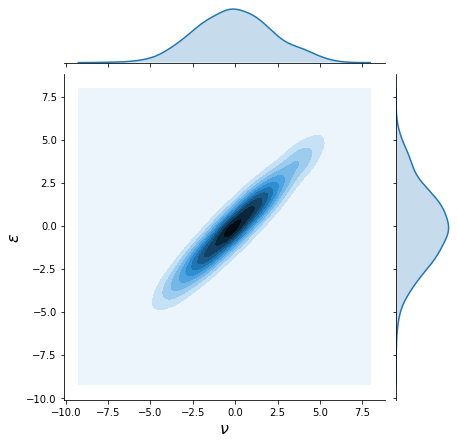

In [2]:
n = 1000  # Number of observations
m = 1500    # Number of potential instruments
k = 10    # Number of covariates
cov = 5
errors = np.random.multivariate_normal(mean = [0,0], cov = [[cov, cov], [cov, cov]], size = n)
h = sns.jointplot(errors[:,0], errors[:,1], kind = 'kde')
h.set_axis_labels('$\\nu$', '$\epsilon$', fontsize=16)

z = np.random.normal(size = (n,m))
x = np.random.normal(size = (n,k))

# Auxilliary equation
nu = errors[:,0]
Pi = np.array([5] + [x if np.random.uniform() > 0.9 else 0 for x in np.random.uniform(low = -2, high = 5, size = m - 1)])
gamma = np.array([5] + [x if np.random.uniform() > 0.9 else 0 for x in np.random.uniform(low = -2, high = 5, size = k - 1)])

d = z @ Pi + x @ gamma + nu

# Main equation
u = errors[:,1]
delta = np.array([5] + [x  if np.random.uniform() > 0.9 else 0 for x in np.random.uniform(low = -2, high = 5, size = k - 1)])
alpha = np.random.uniform(1,2)

y = alpha * d  + x @ delta + u

In [68]:
def simulate(n, m, k, plot = True):
    cov = 5
    errors = np.random.multivariate_normal(mean = [0,0], cov = [[cov, cov], [cov, cov]], size = n)
    if plot:
        h = sns.jointplot(errors[:,0], errors[:,1], kind = 'kde')
        h.set_axis_labels('$\\nu$', '$\epsilon$', fontsize=16)

    z = np.random.normal(size = (n,m))
    x = np.random.normal(size = (n,k))

    # Auxilliary equation
    nu = errors[:,0]
    Pi = np.array([5] + [x if np.random.uniform() > 0.9 else 0 for x in np.random.uniform(low = -2, high = 5, size = m - 1)])
    gamma = np.array([5] + [x if np.random.uniform() > 0.9 else 0 for x in np.random.uniform(low = -2, high = 5, size = k - 1)])

    d = z @ Pi + x @ gamma + nu

    # Main equation
    u = errors[:,1]
    delta = np.array([5] + [x  if np.random.uniform() > 0.9 else 0 for x in np.random.uniform(low = -2, high = 5, size = k - 1)])
    alpha = np.random.uniform(1,2)

    y = alpha * d  + x @ delta + u

    return (d,z, Pi, gamma,nu),(y,x, alpha, delta, u)

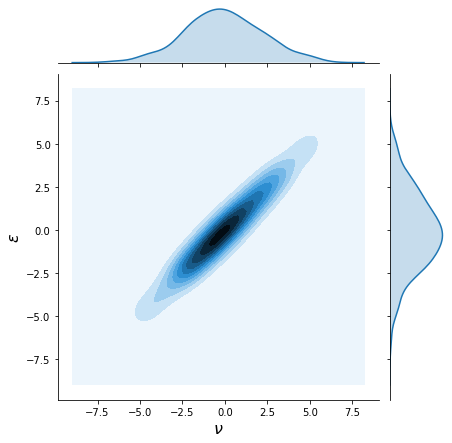

In [69]:
aux,main=simulate(n,m,k,plot=True)
d,z, Pi, gamma,nu=aux
y,x, alpha, delta,u=main

> **Ex. 6.1.2:** Use your function to simulate a new dataset and regress the following OLS regression
>$$
y_i \sim \pi_0 + \pi_1 d_i + \gamma_i
$$
> where $\gamma_i$ is a noise term. 
>
> Repeat this procedure 1000 times in a for loop and store the true $\alpha_0$ as well as the estimate $\pi_1$ in two lists. Plot a histogram of the differences $\alpha_0 - \pi_1$. What does this tell you about the regression you just ran?

In [8]:
from statsmodels.api import OLS, add_constant
from statsmodels.tools import add_constant

In [12]:
# [Your solution here]
p1_, p2_, a = [], [],[]
for i in range(1000):
    aux,main  = simulate(n, m, k, plot=False)
    d,z, Pi, gamma,nu=aux
    y,x, alpha, delta,u=main
    a.append(alpha)
    model=OLS(y,add_constant(d))
    result=model.fit()
    p1, p2 =result.params[0], result.params[1]
    p1_.append(p1)
    p2_.append(p2)

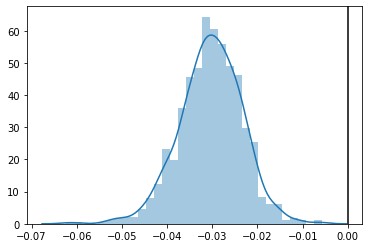

In [21]:
sns.distplot([(x1-x2) for x1,x2 in zip(np.array(a),np.array(p2_))])
plt.axvline(0,color='black')
plt.show()

> **Ex. 6.1.3:** Knowing the DGP an obvious solution would be to run an IV regression, instrumenting $d_i$ with $z_i$. Unfortunately there are $m=1500$ columns in $z_i$ and only $n=1000$ observations. Luckily, the way we have simulated our data only a small subset of the $z_i$'s actually influence $d_i$. The tricky part will be to pick out the right $z_i$'s.
>
> To begin with simulate a new dataset and count the number of non-zero element in $\Pi$ to verify that indeed only very few $z$'s matter for $d$.

In [22]:
# [Your solution here]
aux,main  = simulate(n, m, k, plot=False)
d,z, Pi, gamma,nu=aux
y,x, alpha, delta,u=main

In [25]:
len([i for i in Pi if i !=0])

153

> **Ex. 6.1.4:** The _ideal_ instrument for $d_i$ is exactly the $z_i$'s which have non-zero coefficients, multiplies by the corresponding true simulated parameters in $\delta_0$. Having simulated the data ourselves, an easy way to compute this is to simply calculate
> $$
\hat{d}^* = z \cdot \delta_0
$$
> where $\cdot$ is the dot product, written as `@` in numpy. In reality we cannot get this ideal instrument, because it would require regressing $d_i$ on all 500 variables with only 100 observations.  
>
> In a for loop over 1000 iterations, simulate new data, compute the ideal instrument $\hat{d_i}$ and regress the second stage regression $y_i \sim \pi_0 + \pi_1\hat{d_i}$. Store the true $\alpha_0$ and the estimate $\hat{\pi}_1$ in two lists. Finally draw a histogram of the differences $\alpha_0 - \hat{\pi}_1$. How does your histogram look this time, is this expected?

In [29]:
# [Your solution here]
A,B = [], []
for i in range(1000):
    aux,main=simulate(n, m, k,plot=False)
    d,z, Pi, gamma,nu=aux
    y,x, alpha, delta,u=main
    d_hat = z @ Pi
    beta_1= OLS(y, add_constant(d_hat)).fit().params[1]
    A.append(alpha)
    B.append(beta_1)

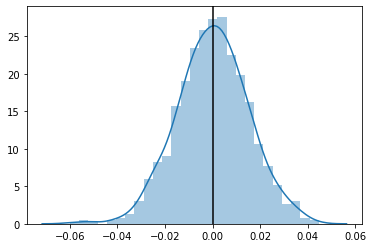

In [31]:
sns.distplot([(x1-x2) for x1,x2 in zip(A,B)])
plt.axvline(0,color='black')
plt.show()

> **Ex. 6.1.5:** The below class implements post-lasso. A two step procedure where first a lasso model is used to identify relevant parameters, and then OLS is used to estimate parameter values on the remaining variables. Study the code, and understand as well as possible what is going on. 
>
> What is stored in `relevant_x`?
> 
> Why is the `predict` method so complicated?

In [32]:
from sklearn.linear_model import LassoCV, Lasso
from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning

C:\Users\mgd405\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)


In [33]:
class PostLasso:
    def __init__(self, formula = None):
        self.lasso_model = Lasso()
        self.ols_model = None
        self.relevant_x = None
        self.subset_cols = None
        self.coefs = None
        self.formula = formula
    
    def __repr__(self):
        return f'PostLasso({self.formula})'
    
    @ignore_warnings(category=ConvergenceWarning)
    def fit(self, X, y, force_include_idx = None):
        ''' Estimate a model using Post-Lasso
        
        X: X matrix (without intercept)
        y: y vector
        force_include_idx: column indexes that ALWAYS is
            included in the OLS model, regardless of their
            status in the lasso stage.
        '''
        self.lasso_model = self.lasso_model.fit(X,y)
        self.coefs = np.insert(self.lasso_model.coef_, 0, self.lasso_model.intercept_)
        self.subset_cols = np.where(self.coefs != 0)[0]
        if force_include_idx is not None:
            self.subset_cols = np.union1d(self.subset_cols, force_include_idx)
        self.relevant_x = add_constant(X)[:,self.subset_cols]
        self.ols_model = OLS(y, self.relevant_x).fit()
        return self

    def predict(self, X = None):
        ''' Predict using a fitted post-lasso model.
        '''
        if X is None:
            return self.ols_model.predict(self.relevant_x)
        if X.shape == self.relevant_x.shape:
            return self.ols_model.predict(X)
        return self.ols_model.predict(X[:,self.subset_cols])

> **Ex. 6.1.6:** In this problem we will try to run through the post-lasso steps required to obtain an estimate of $\alpha_0$. Since we are doing this in python we will not be able to set the lasso hyperparameter optimally for this kind of post-selection usage. There is a R package, developed especially to handle inference after lasso-selection, which you should use in practise. 
>
> For now, do the following steps 1000 times, storing the true $\alpha_0$ and estimate $\hat{\alpha_0}$:
>
> * 0. Simulate a new dataset.
> * 1. Run a post-lasso regression of d on x and z, $d_i \sim x_i'\gamma + z_i' \delta$, forcing the inclusion of $x_i$ in the OLS stage.
> * 2. Run the second stage regression $y_i \sim \hat{d}_i + x_i' \beta$ to recover $\hat{\alpha_0}$.
>
> How does this histogram compare to the naive one? How does it compare to the ideal one?
>
> _Hint:_ We follow the description given on page 19 [here](https://cran.r-project.org/web/packages/hdm/vignettes/hdm.pdf).

In [37]:
# [Your solution here]
A,B = [], []
%time
for i in range(1000):
    aux,main=simulate(n, m, k,plot=False)
    d,z, Pi, gamma,nu=aux
    y,x, alpha, delta,u=main
    dxz = PostLasso('di ~ xi + zi')
    dxz.fit(np.c_[x, z], d, force_include_idx = np.arange(x.shape[1]))
    x_pred = np.c_[x, dxz.predict()]
    result= OLS(y, x_pred).fit()
    bhat=result.params[-1]
    A.append(alpha)
    B.append(bhat)

Wall time: 0 ns


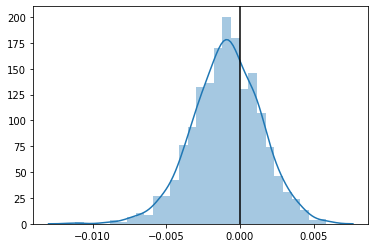

In [38]:
sns.distplot([(x1-x2) for x1,x2 in zip(A,B)])
plt.axvline(0,color='black')
plt.show()